In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.colors,  matplotlib.cm as cm, os, sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

home = os.path.abspath( os.getcwd() + "/.." )
sys.path.append(home)


In [2]:
def ASM_prop(surface_pressure, cell_spacing, target_dist, resolution, k):
    """
    Propagate complex pressure forward to a parallel plane at a given resolution.
    Returns a complex pressure field.
    
    params:
    surface_pressure = complex surface pressure
    cell_spacing = seperation between cells on the metasurface
    target_dist = distance to propagation plane
    resolution = returns this many sample points for each point in the input phasemap
    k = wavenumber
    """
    f = np.kron(surface_pressure, np.ones((resolution, resolution)))
    Nfft = f.shape
    kx = (2*np.pi*(np.arange(-Nfft[0]/2, (Nfft[0])/2)/((cell_spacing/resolution)*Nfft[0]))).reshape((1, Nfft[0])) # kx vector
    ky = (2*np.pi*(np.arange(-Nfft[1]/2, (Nfft[1])/2)/((cell_spacing/resolution)*Nfft[1]))).reshape((1, Nfft[1])) # ky vector
    F = np.fft.fft2(f) # 2D FT
    F = np.fft.fftshift(F) # Shift to the centre
    ## Propagate forwards    
    H = np.exp(1j*np.lib.scimath.sqrt(k**2 - kx**2 - (ky**2).T)*target_dist) # propagator function
    Gf = F*H.T # propagating the signal forward in Fourier space
    gf = np.fft.ifft2(np.fft.ifftshift(Gf)) # IFT & shift to return to real space
    return gf

In [3]:
    
def ASM_prop_perpendicular(surface_pressure, cell_spacing, target_dist, z_height, cut_axis, resolution, k):
    """
    Propagate complex pressure forward to a perpendicular plane at a given resolution.
    Returns a complex pressure field.
    
    Args:
        surface_pressure: complex surface pressure.
        cell_spacing: seperation between cells on the metasurface.
        target_dist: distance to propagation plane.
        z_height: how far in the z-axis we want to propagate [m]
        cut_axis: are we slicing in the x or y axes?
        resolution: returns this many sample points for each point in the input phasemap.
        k: wavenumber
    """
    if cut_axis == "x":
        centrepoint = int(surface_pressure.shape[0]*resolution/2)
        
    elif cut_axis == "y":
        centrepoint = int(surface_pressure.shape[1]*resolution/2)
        
    else:
        print(cut_axis, "is not a valid axis, please enter 'x' or 'y'.")
        return 
    
    step = cell_spacing/resolution
    prop_range = np.arange(0, z_height + step, step)
    xy_pressure_list = []
    for target_dist in prop_range:
        propagation = ASM_prop(surface_pressure, cell_spacing, target_dist, resolution, k)
        if cut_axis == "x":
            central_abs_pressure_vector = abs(propagation)[centrepoint]
        elif cut_axis == "y":
            central_abs_pressure_vector = abs(propagation.T)[centrepoint]
        xy_pressure_list.append(central_abs_pressure_vector)

    return np.flipud(np.array(xy_pressure_list))
    

evpsl 0.08574999999999999
dx 0.0042875
32
[-0.06645625 -0.06216875 -0.05788125 -0.05359375 -0.04930625 -0.04501875
 -0.04073125 -0.03644375 -0.03215625 -0.02786875 -0.02358125 -0.01929375
 -0.01500625 -0.01071875 -0.00643125 -0.00214375  0.00214375  0.00643125
  0.01071875  0.01500625  0.01929375  0.02358125  0.02786875  0.03215625
  0.03644375  0.04073125  0.04501875  0.04930625  0.05359375  0.05788125
  0.06216875  0.06645625]
dx 0.0042875
z_height 0.17149999999999999


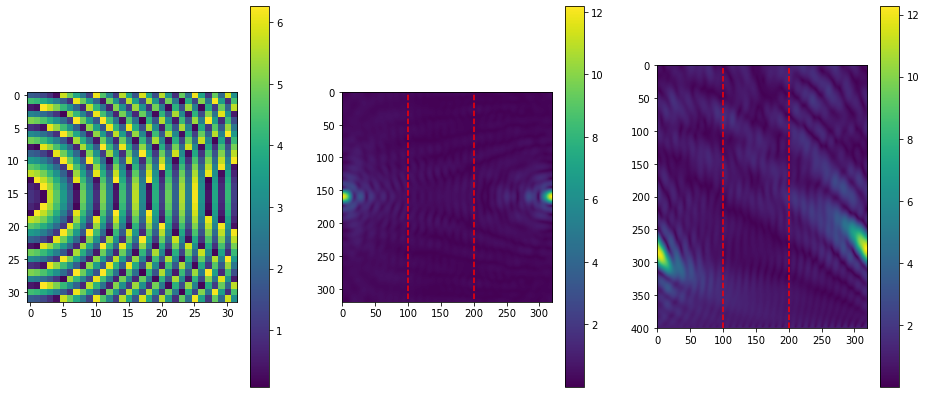

In [4]:
import numpy as np, matplotlib.pyplot as plt
# ---> physics params <---
c = 343 # m/s
v = 40000 # Hz
lam = c/v # m
k = 2*np.pi/lam # rads/m

elem_num = 32 # number of elems along one side of the AMM surface

# evpsl = 4*(elem_num/4)*lam # evaluation plane side length
evpsl = 10*lam # evaluation plane side length
print(f"evpsl {evpsl}")


dx = lam/2 # [m]
print(f"dx {dx}")

# apsize = (int(2*evpsl/dx), int(2*evpsl/dx)) # AMM aperture size (number of unit cells)
apsize = (32, 32) # AMM aperture size (number of unit cells)

focal_length = 0.05 # focal length of the AMM [m]

x_shift, y_shift = 8*lam, 0


xy_vec = np.arange(-((apsize[0]/2)-0.5)*dx, ((apsize[0]/2)+0.5)*dx, dx)


print(len(xy_vec))
print(xy_vec)

xx, yy = np.meshgrid(xy_vec, xy_vec)

# print(yy)

travel_distance_array = np.sqrt((xx+x_shift)**2 + (yy+y_shift)**2 + (focal_length**2)) # matrix of distances from centre of each elem to focus

total_phase_array = -travel_distance_array * k # total change in phase of waves as they travel this distance.

norm_phase_array = np.remainder(total_phase_array, 2*np.pi) # normalise between 0 and 2π [rads].

AMM_phase_distribution = norm_phase_array # phase on the surface rewuired to perform focusing, assuming incident plane wave.

AMM_phase_tt_distribution = AMM_phase_distribution.copy() 

# AMM_phase_tt_distribution[(len(AMM_phase_distribution)/2):] = AMM_phase_tt_distribution[len(AMM_phase_distribution)/2:] + np.pi
AMM_phase_tt_distribution[16:] = AMM_phase_tt_distribution[16:] + np.pi

# print(norm_phase_array)

resolution = 10

# ASM_prop(np.ones_like(AMM_phase_distribution),  surface_pressure, cell_spacing, target_dist, resolution, k)
tt_prop = ASM_prop(np.ones_like(AMM_phase_distribution)*np.exp(1j*AMM_phase_distribution),
        dx, 
        focal_length,
        resolution, 
        k)


tt_prop_perp = ASM_prop_perpendicular(np.ones_like(AMM_phase_distribution)*np.exp(1j*AMM_phase_distribution),
        dx, 
        focal_length,
        z_height = 20* lam,
        cut_axis = "x",
        resolution = resolution, 
        k = k)

print(f"dx {dx}")
print(f"z_height {20*lam}")

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,7))

im1 = ax1.imshow(AMM_phase_distribution)
im2 = ax2.imshow(np.abs(tt_prop))
im3 = ax3.imshow(np.abs(tt_prop_perp))

ax2.vlines([100, 200], 315, 0, linestyles='dashed', colors='red')
ax3.vlines([100, 200], 400, 1, linestyles='dashed', colors='red')

plt.colorbar(im1, ax = ax1)
plt.colorbar(im2, ax = ax2)
plt.colorbar(im3, ax = ax3)
plt.show()

